<a href="https://colab.research.google.com/github/hiydavid/homl-learning/blob/main/projects/tf_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Training Loop

---
## Load libraries & data

In [1]:
# load libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras

# check version
print('matplotlib v.', mpl.__version__)
print('numpy v.', np.__version__)
print('pandas v.', pd.__version__)
print('sklearn v.', sklearn.__version__)
print('tensorflow v.', tf.__version__)
print('keras v.', keras.__version__)

matplotlib v. 3.2.2
numpy v. 1.19.5
pandas v. 1.1.5
sklearn v. 0.22.2.post1
tensorflow v. 2.5.0
keras v. 2.5.0


In [2]:
# load data & normalize
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4423680/4422102 [==============================] - 0s 0us/step


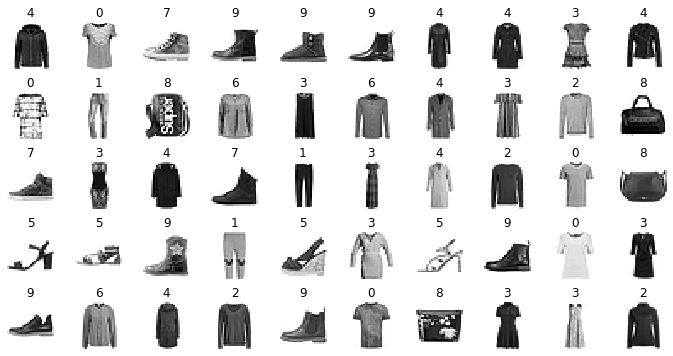

In [5]:
# show examples of the images from mnist
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
# function to clear session & set seed
def clear_session(seed = 1234):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

clear_session()

---
# Build model

In [6]:
# build model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [7]:
# set model hyperparamters
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

---
## Custom functions

In [11]:
# random batch
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [14]:
# print status bar
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [15]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

---
## Custom training loop

In [18]:
from tqdm.notebook import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs") as epochs:

    for epoch in epochs:

        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:

            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()

                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                
                steps.set_postfix(status)
            
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(
                keras.metrics.sparse_categorical_accuracy(
                    tf.constant(y_valid, dtype=np.float32),
                    y_pred
                )
            )
            steps.set_postfix(status)
        
        for metric in [mean_loss] + metrics:
            metric.reset_states()